This notebook is divided into the below sections:

1. Problem Stement
2. Importing libraries
3. Data Reading and basic understanding
4. Data Cleaning
    -removing outliers
    -renaming columns
5. Univariate and Multivariate Analysis
    - study correlation for understanding linear regression fit
6. Linear Regression model building
    - RFE, MFE
    - VIF and P values boundaries
7. Evaluation of the model on test dataset
8. Ridge and Lasso Regression
9. Linear regression charateristics and model Explaination


### Step 1 Problem Statement

Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

### Step 2 Importing Libraries

In [3232]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler, PolynomialFeatures

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale


### Step 3 Reading dataset

In [3233]:
#reading the dataset into pandas dataframe
housing=pd.read_csv("train.csv",  low_memory=False)
housing.shape


(1460, 81)

In [3234]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Step 4 Data Cleaning

<AxesSubplot:>

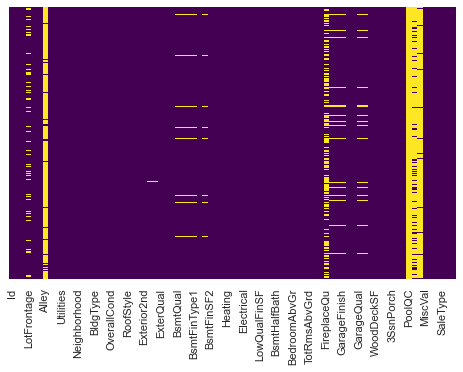

In [3235]:
sns.heatmap(housing.isnull(),yticklabels=False,cbar=False, cmap="viridis")

In [3236]:
nullcount=housing.isna().sum()
nullcount

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

###  Remove columns with all null values

In [3237]:

columnslistwithallnull =[]
columnslisttoconsider= []
for index, value in nullcount.items():
    if value==len(housing):
       columnslistwithallnull.append(index) 
    else:
       columnslisttoconsider.append(index)
print("Columns to drop as they have all null values:", len(columnslistwithallnull))
#print(" Dropped columns in this step", columnslistwithallnull)
print("Remaining columns", len(columnslisttoconsider)) 

Columns to drop as they have all null values: 0
Remaining columns 81


###   Remove columns with same value across the dataset, these columns will not be useful to analysis

In [3238]:

newcolstoconsider=[]
samevaluecols=[]
for i in columnslisttoconsider:
    if len(housing[i].value_counts())==1:
       samevaluecols.append(i) 
    else:
       newcolstoconsider.append(i)
print("Columns to drop as they have all same values:", len(samevaluecols)) 
#print(" Dropped columns in this step", samevaluecols)
print("Remaining columns", len(newcolstoconsider)) 

Columns to drop as they have all same values: 0
Remaining columns 81


###  Remove columns where there are all distinct values, this is not useful for our analysis

In [3239]:
alldistinctvalues=[]
for index,value in housing.nunique().items():
    if value == len(housing):
        alldistinctvalues.append(index)
print(alldistinctvalues)

# Clearly, these columns can also be remmoved as they wont add value in the analysis

['Id']


In [3240]:
housing=housing.drop(axis=1,  columns=alldistinctvalues)

###  Null values
#### Criteria is if null values is greater than 60% 

In [3241]:
mostnullvalues=[]
for index,value in housing.isna().sum().items():
    if value > len(housing)*0.8:
        mostnullvalues.append(index)
print(mostnullvalues)




['Alley', 'PoolQC', 'Fence', 'MiscFeature']


### According to dataset definition Alley, Fence, PoolQC, MiscFeature  has a value NA if No Alley Access, or no fence hence this is not a missing value. However we can still drop these as the dataset has 80% of values with same data

### Dropping these as most of them have same data in 80% records

In [3242]:

mostnullvalues
# housing["Alley"].fillna("No Alley Access")

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [3243]:
housing=housing.drop(axis=1,  columns=mostnullvalues)

In [3244]:
print(housing.shape)
print("There are a total of", housing.shape[0] ,"rows and ",housing.shape[1]," coloumns")

(1460, 76)
There are a total of 1460 rows and  76  coloumns


In [3245]:
nullcount=housing.isna().sum()
nullcount

# checking null values
nullcount = housing.isnull().sum()
# find out columns which have nulls
nullcount = nullcount[nullcount > 0]
# % of columns missing
print(round(100*nullcount[nullcount > 0]/len(housing),2))

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64


### Filling NA in garage columns with No Garage as per data definition

In [3246]:
garageCols=["GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond"]
for col in garageCols:
    housing[col].fillna('No Garage', inplace=True)



### Filling NA in FireplaceQu column with No Fireplace as per data definition

In [3247]:
housing["FireplaceQu"].fillna('No Fireplace', inplace=True)

### the null count percentage table shows that the basement columns has a few incorrect records, removing the two records as they lead to inconsistemt data

In [3248]:
housing[housing["BsmtFinType2"].isna()][["BsmtFinType2","BsmtFinType1"]]
print(housing[(housing["BsmtFinType2"].isna()) & ~(housing["BsmtFinType1"].isna())][["BsmtFinType2","BsmtFinType1"]].index)
housing=housing.drop(332)

Int64Index([332], dtype='int64')


In [3249]:

print(housing[(housing["BsmtExposure"].isna()) & ~(housing["BsmtFinType1"].isna())][["BsmtFinType2","BsmtFinType1","BsmtExposure"]].index)
housing=housing.drop(948)

Int64Index([948], dtype='int64')


### Filling NA in Basement column with No Basement as per data definition

In [3250]:
basementCols=["BsmtFinType2","BsmtFinType1","BsmtExposure","BsmtQual","BsmtCond"]
for col in basementCols:
    housing[col].fillna('No Basement', inplace=True)

In [3251]:
housing

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


In [3252]:
numeric_cols_nulls=[]
category_cols_nulls=[]
for column in nullcount.index:
    if housing[column].dtype.name == "object":
        category_cols_nulls.append(column)
    else:
        numeric_cols_nulls.append(column)
print(category_cols_nulls)
print(numeric_cols_nulls)

['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
['LotFrontage', 'MasVnrArea']


In [3253]:
nullcount=housing.isna().sum()
nullcount

# checking null values
nullcount = housing.isnull().sum()
# find out columns which have nulls
nullcount = nullcount[nullcount > 0]
# % of columns missing
print(round(100*nullcount[nullcount > 0]/len(housing),2))

LotFrontage    17.76
MasVnrType      0.55
MasVnrArea      0.55
Electrical      0.07
dtype: float64


### Treating the remaining missing values with median for continuous and mode for categorical

In [3254]:

nullcount=housing.isna().sum()
for column in nullcount.index:
    if housing[column].dtype.name == "object":
        housing[column].fillna(housing[column].mode()[0], inplace=True)


In [3255]:
nullcount=housing.isna().sum()
for column in nullcount.index:
    if housing[column].dtype.name != "object":
        housing[column].fillna(housing[column].median(), inplace=True)

### All missing values are now treated

<AxesSubplot:>

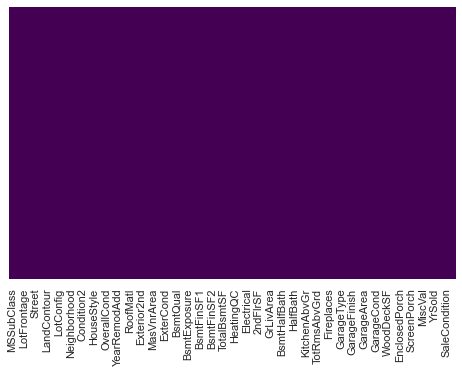

In [3256]:
sns.heatmap(housing.isnull(),yticklabels=False,cbar=False, cmap="viridis")

In [3257]:
housing.shape

(1458, 76)

In [3258]:
housing.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

### Splitting columns into two sets, continuous/numeric and categorical columns

In [3259]:
numeric_cols=[]
category_cols=[]
for column in housing.columns:
    if housing[column].dtype.name == "object":
        category_cols.append(column)
    else:
        numeric_cols.append(column)
print(category_cols)
print(numeric_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Pool

### Transforming Columns to meaningful values 

### Transforming Year columns to age of property

In [3261]:
##Derive a new variable named 'AgeofProperty' to determine the age of property since the built

def find_age_since_built(row):
        return row['YrSold'] - row['YearBuilt']
    
housing['AgeofProperty'] = housing.apply(find_age_since_built, axis=1)
housing.head()  
housing.drop(['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt'], axis=1, inplace = True)

### Transforming MSSubClass columns to categorical based on data definition as they are not ordered

In [3262]:
#changing num to categorical so as to form these as dummy variables 
housing['MSSubClass']=housing['MSSubClass'].replace({20:'1-STORY 1946 & NEWER ALL STYLES',30:'1-STORY 1945 & OLDER',40:'1-STORY W/FINISHED ATTIC ALL AGES',45:'1-1/2 STORY - UNFINISHED ALL AGES',50:'1-1/2 STORY FINISHED ALL AGES',60:'2-STORY 1946 & NEWER',70:'2-STORY 1945 & OLDER',75:'2-1/2 STORY ALL AGES',80:'SPLIT OR MULTI-LEVEL',85:'SPLIT FOYER',90:'DUPLEX - ALL STYLES AND AGES',120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',150:'1-1/2 STORY PUD - ALL AGES',160:'2-STORY PUD - 1946 & NEWER',180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'})

### Transforming OverallQual and OverallCond columns to categorical

In [3263]:
housing['OverallQual']=housing['OverallQual'].replace({ 10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'})
housing['OverallCond']=housing['OverallCond'].replace({ 10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'})

In [3264]:
numeric_cols=[]
category_cols=[]
for column in housing.columns:
    if housing[column].dtype.name == "object":
        category_cols.append(column)
    else:
        numeric_cols.append(column)
print(category_cols)
print(numeric_cols)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice', 'Ag

### Checking for outliers and removing columns where data is highly skewed

<Figure size 576x360 with 0 Axes>

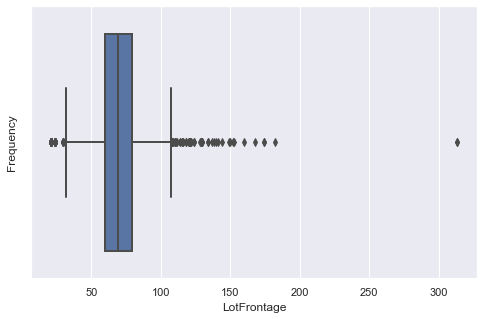

<Figure size 576x360 with 0 Axes>

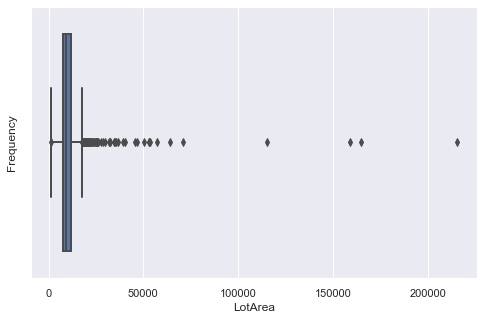

<Figure size 576x360 with 0 Axes>

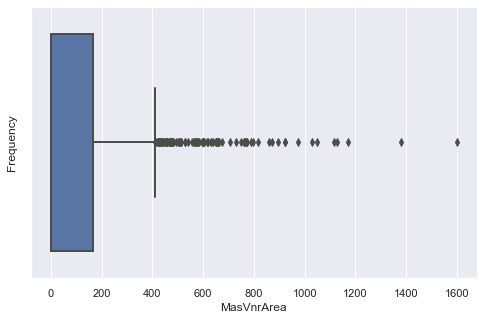

<Figure size 576x360 with 0 Axes>

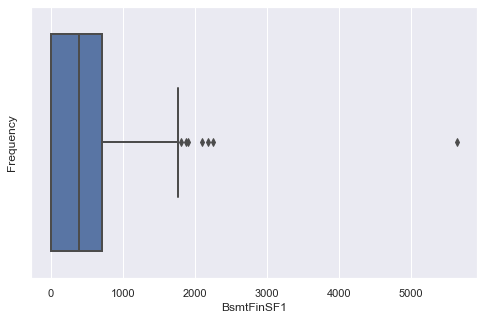

<Figure size 576x360 with 0 Axes>

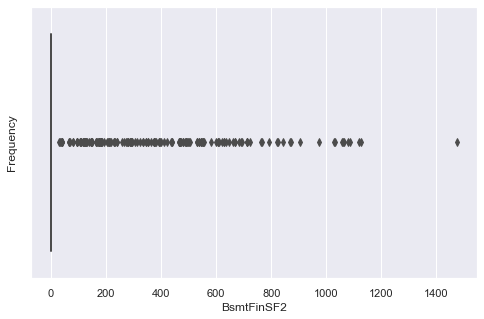

<Figure size 576x360 with 0 Axes>

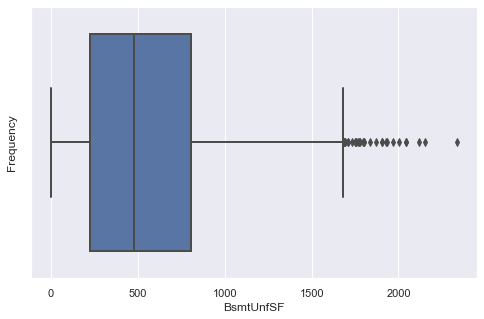

<Figure size 576x360 with 0 Axes>

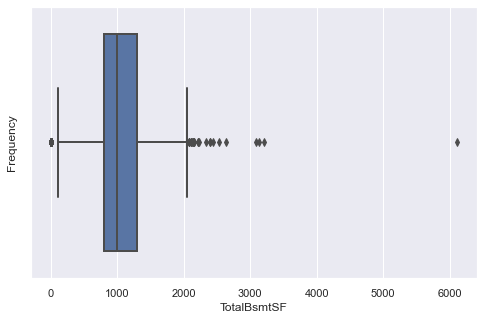

<Figure size 576x360 with 0 Axes>

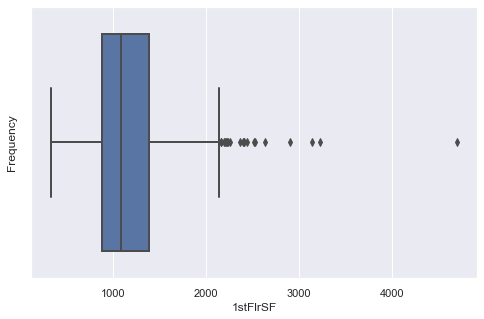

<Figure size 576x360 with 0 Axes>

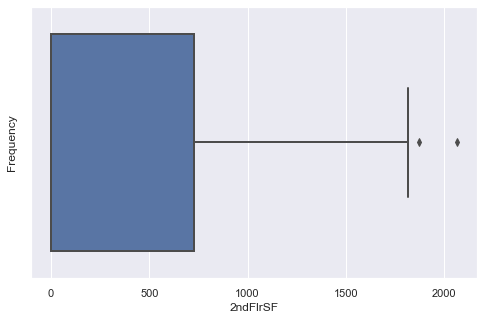

<Figure size 576x360 with 0 Axes>

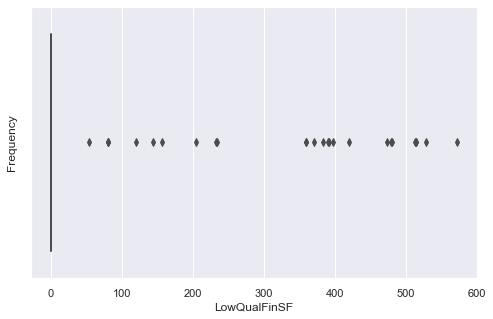

<Figure size 576x360 with 0 Axes>

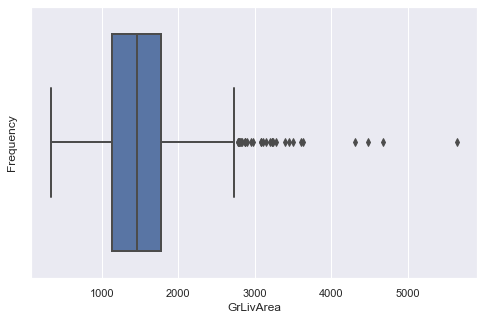

<Figure size 576x360 with 0 Axes>

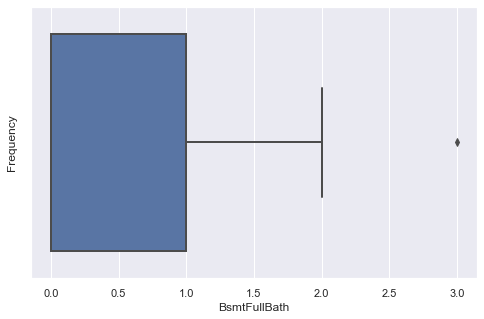

<Figure size 576x360 with 0 Axes>

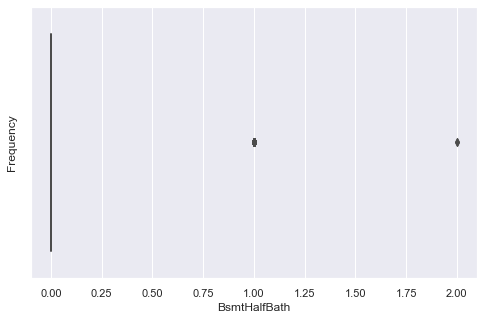

<Figure size 576x360 with 0 Axes>

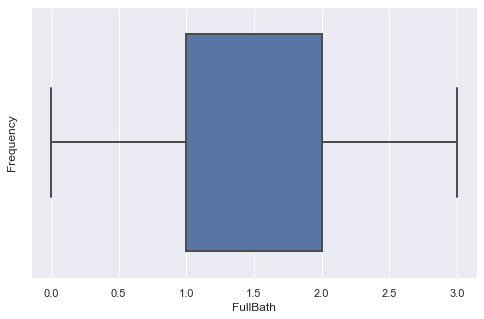

<Figure size 576x360 with 0 Axes>

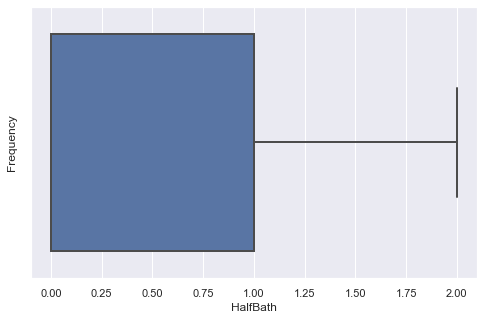

<Figure size 576x360 with 0 Axes>

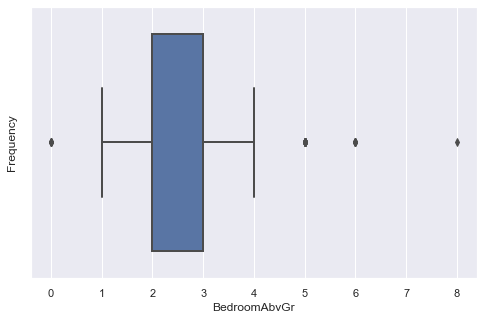

<Figure size 576x360 with 0 Axes>

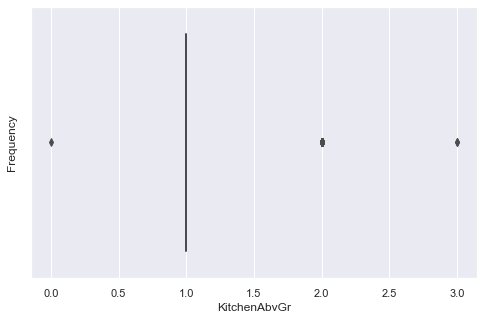

<Figure size 576x360 with 0 Axes>

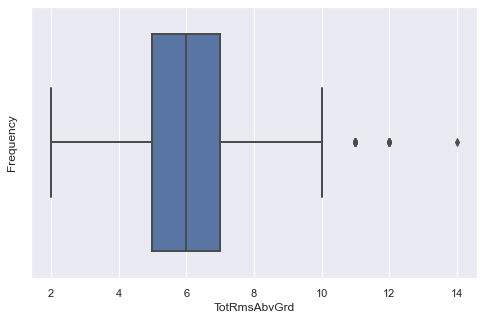

<Figure size 576x360 with 0 Axes>

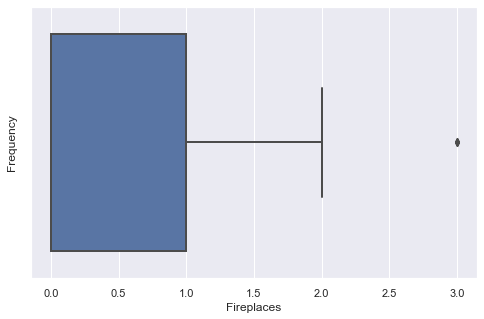

<Figure size 576x360 with 0 Axes>

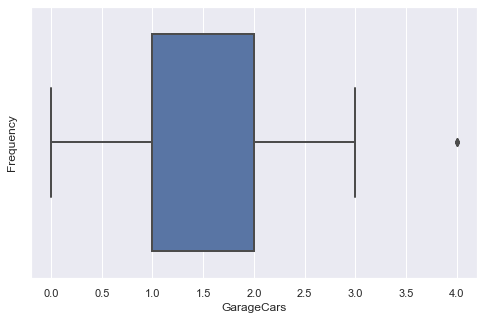

<Figure size 576x360 with 0 Axes>

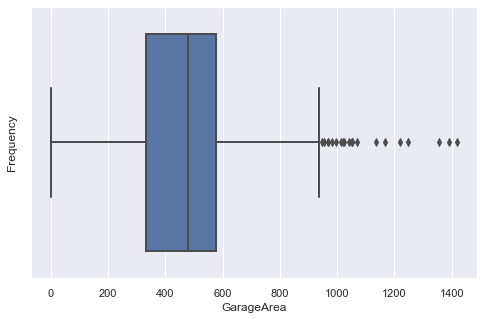

<Figure size 576x360 with 0 Axes>

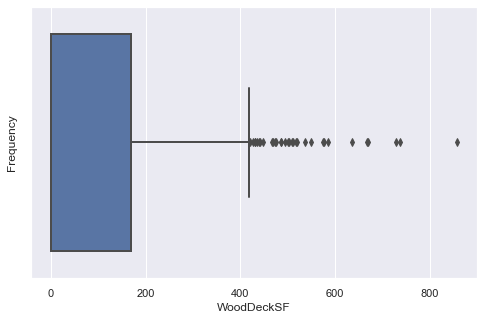

<Figure size 576x360 with 0 Axes>

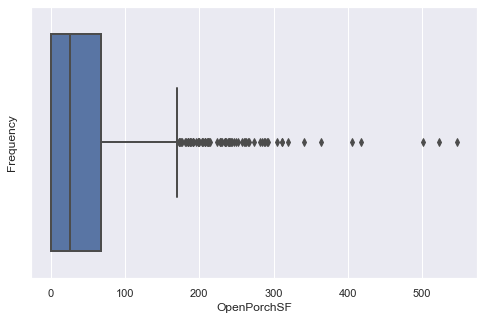

<Figure size 576x360 with 0 Axes>

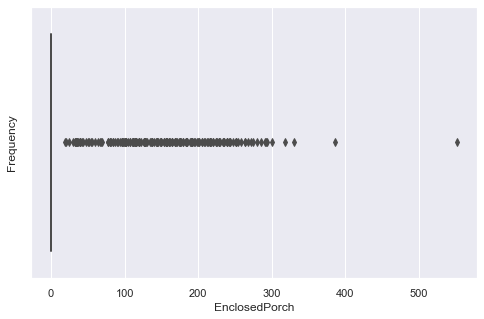

<Figure size 576x360 with 0 Axes>

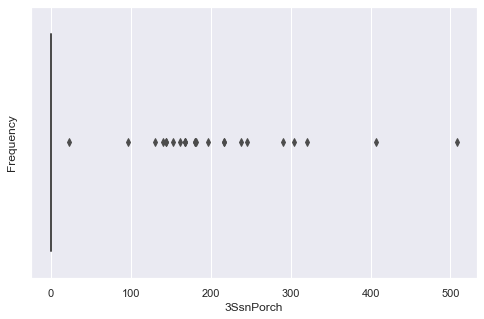

<Figure size 576x360 with 0 Axes>

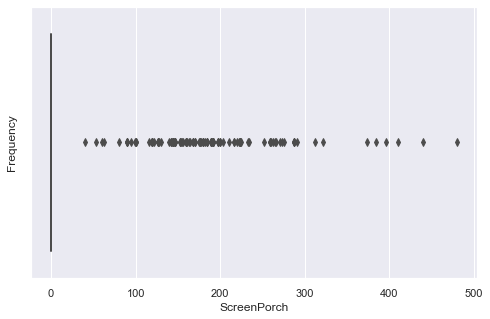

<Figure size 576x360 with 0 Axes>

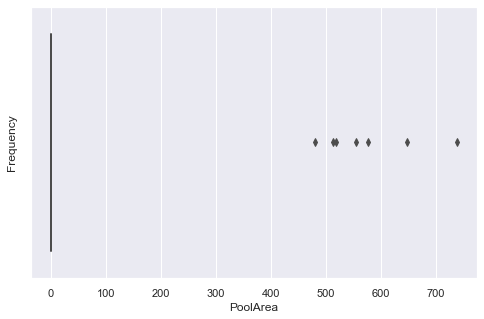

<Figure size 576x360 with 0 Axes>

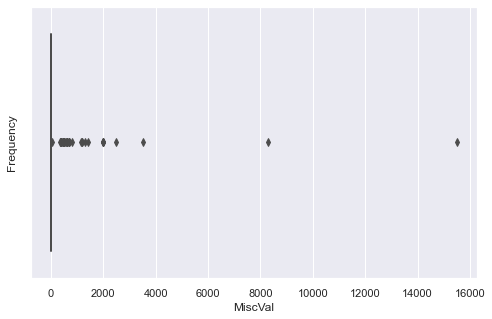

<Figure size 576x360 with 0 Axes>

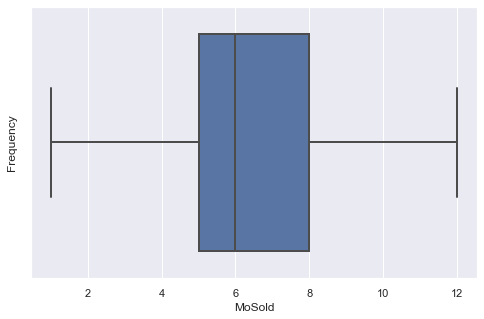

<Figure size 576x360 with 0 Axes>

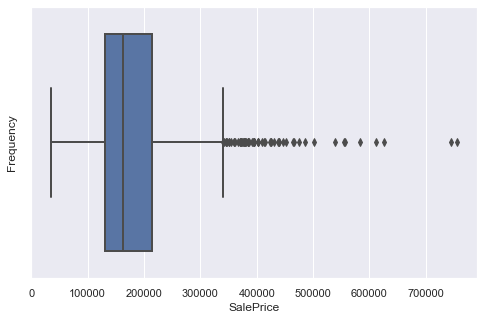

<Figure size 576x360 with 0 Axes>

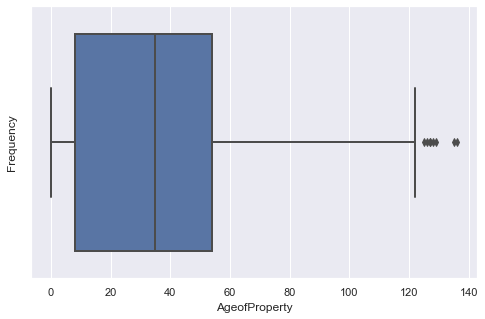

In [3265]:
for i in numeric_cols:
    plt.figure()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box) = plt.subplots(1)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(housing[i], ax=ax_box , linewidth= 2.0)

### checking for outliers in all columns and dropping columns with outliers > 8%, not treating outliers as it will lead to data loss

In [3266]:

for col in numeric_cols:

    thresholds=outlierthreshold(col)
    upper=thresholds["upper"]
    lower=thresholds["lower"]

    percentage_removed=len(housing[housing[col]>upper])/len(housing)*100
    print(round(percentage_removed,2), "% data has "+ col +" greater than the upper threshold", upper)
    percentage_removed_lower=len(housing[housing[col]<lower])/len(housing)*100
    print(round(percentage_removed_lower,2), "% data has "+col+" lesser than the lower threshold", lower)
#     housing=housing[(housing[col] > lower) & (housing[col] < upper)]


3.98 % data has LotFrontage greater than the upper threshold 107.5
3.29 % data has LotFrontage lesser than the lower threshold 31.5
4.6 % data has LotArea greater than the upper threshold 17683.25
0.07 % data has LotArea lesser than the lower threshold 1461.25
6.72 % data has MasVnrArea greater than the upper threshold 410.0
0.0 % data has MasVnrArea lesser than the lower threshold -246.0
0.48 % data has BsmtFinSF1 greater than the upper threshold 1780.0
0.0 % data has BsmtFinSF1 lesser than the lower threshold -1068.0
11.39 % data has BsmtFinSF2 greater than the upper threshold 0.0
0.0 % data has BsmtFinSF2 lesser than the lower threshold 0.0
1.99 % data has BsmtUnfSF greater than the upper threshold 1684.25
0.0 % data has BsmtUnfSF lesser than the lower threshold -653.75
1.58 % data has TotalBsmtSF greater than the upper threshold 2051.5
2.54 % data has TotalBsmtSF lesser than the lower threshold 41.5
1.37 % data has 1stFlrSF greater than the upper threshold 2154.5
0.0 % data has 1st

In [3267]:
#features_with_MANY_outliers=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF2','BsmtHalfBath','OpenPorchSF','EnclosedPorch','ScreenPorch','GarageYrBlt_Age']

In [3268]:
features_with_MANY_outliers=['BsmtFinSF2','EnclosedPorch','ScreenPorch']

In [3269]:
housing= housing.drop(features_with_MANY_outliers,axis=1)     

In [3270]:
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,3SsnPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,AgeofProperty
0,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,61,0,0,0,2,WD,Normal,208500,5
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,298,0,0,0,0,5,WD,Normal,181500,31
2,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,42,0,0,0,9,WD,Normal,223500,7
3,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,35,0,0,0,2,WD,Abnorml,140000,91
4,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,192,84,0,0,0,12,WD,Normal,250000,8


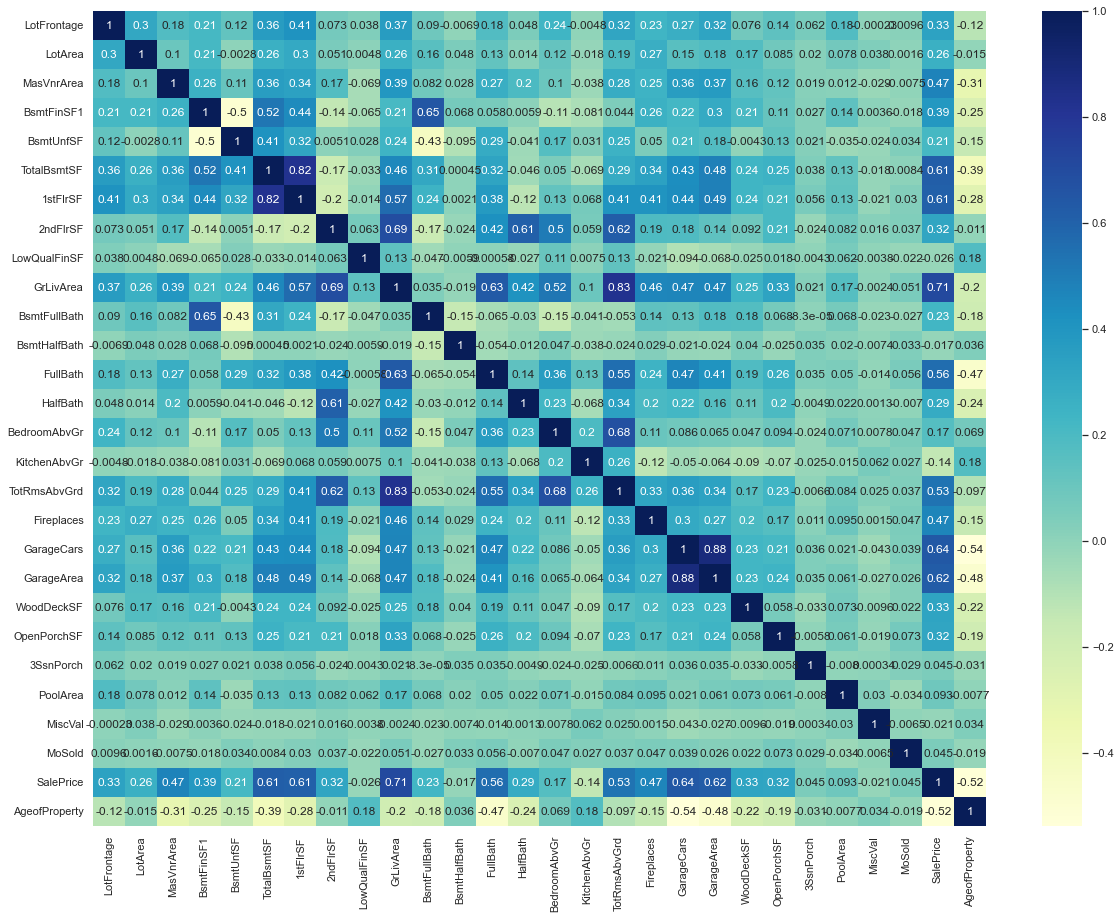

In [3271]:
housing_numeric = housing.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()
# correlation matrix
cor = housing_numeric.corr()
cor
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(20,15))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

### Inferences from  above visualization
1. GrtLiveArea and SalePrice are positively correlated
2. Highest correlation between GarageArea and Garage cars (need to check for collinearity)
3. TotRmsAbvGr and GrLivarea are positively correlated (need to check for collinearity)

### Checking on Output variable and applying log for removing skewness

In [3272]:
#skewness and kurtosis
print("Skewness: %f" % housing['SalePrice'].skew())

Skewness: 1.886364


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

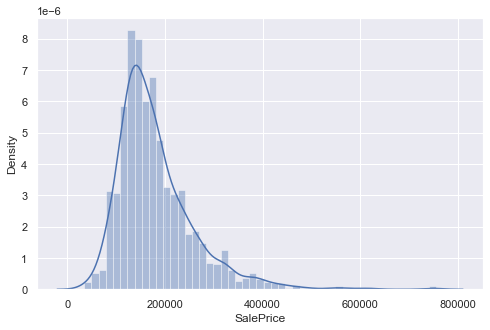

In [3273]:
sns.distplot(housing['SalePrice'])

In [3274]:
housing["SalePrice"]=np.log(housing["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

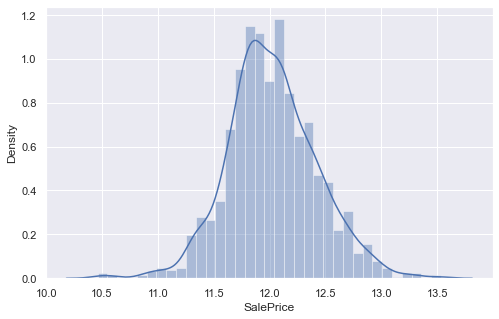

In [3275]:
sns.distplot(housing['SalePrice'])

### Analyzing categorical columns

In [3276]:
category_cols

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

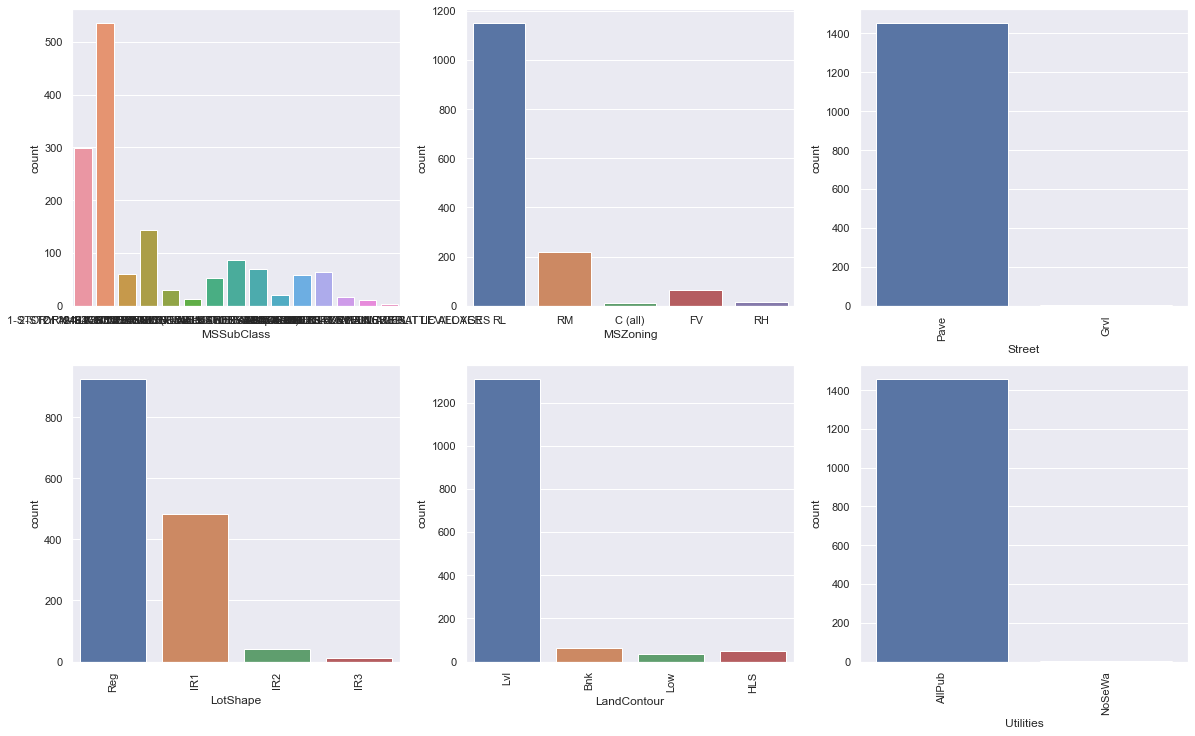

In [3277]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[0],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[1], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[2], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[3], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[4],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[5],  data = housing)
plt.xticks(rotation=90)
plt.show()

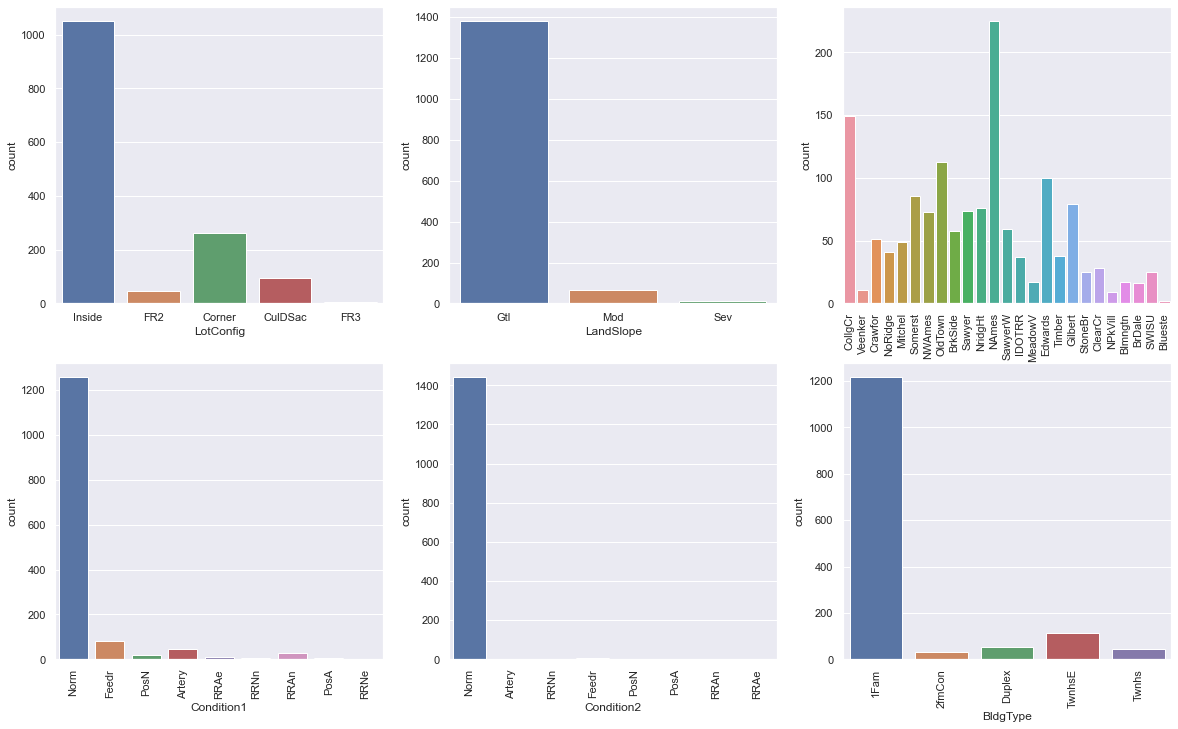

In [3278]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[6],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[7], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[8], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[9], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[10],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[11],  data = housing)
plt.xticks(rotation=90)
plt.show()

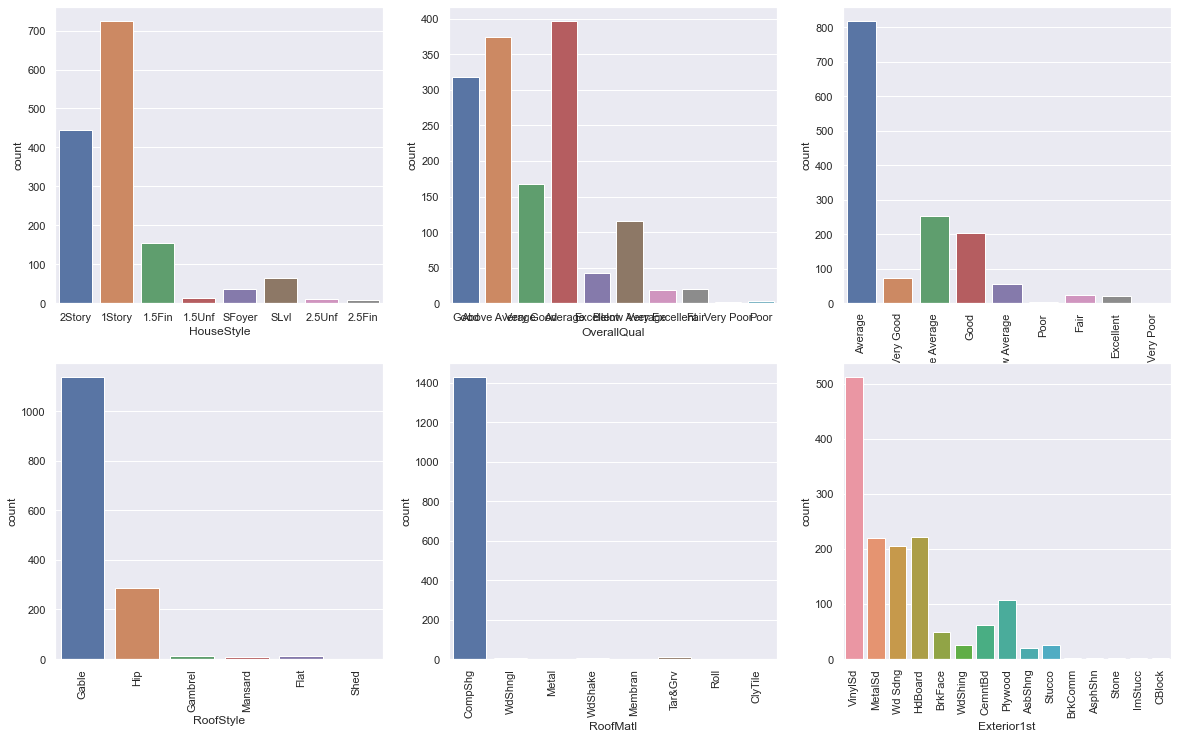

In [3279]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[12],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[13], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[14], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[15], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[16],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[17],  data = housing)
plt.xticks(rotation=90)
plt.show()

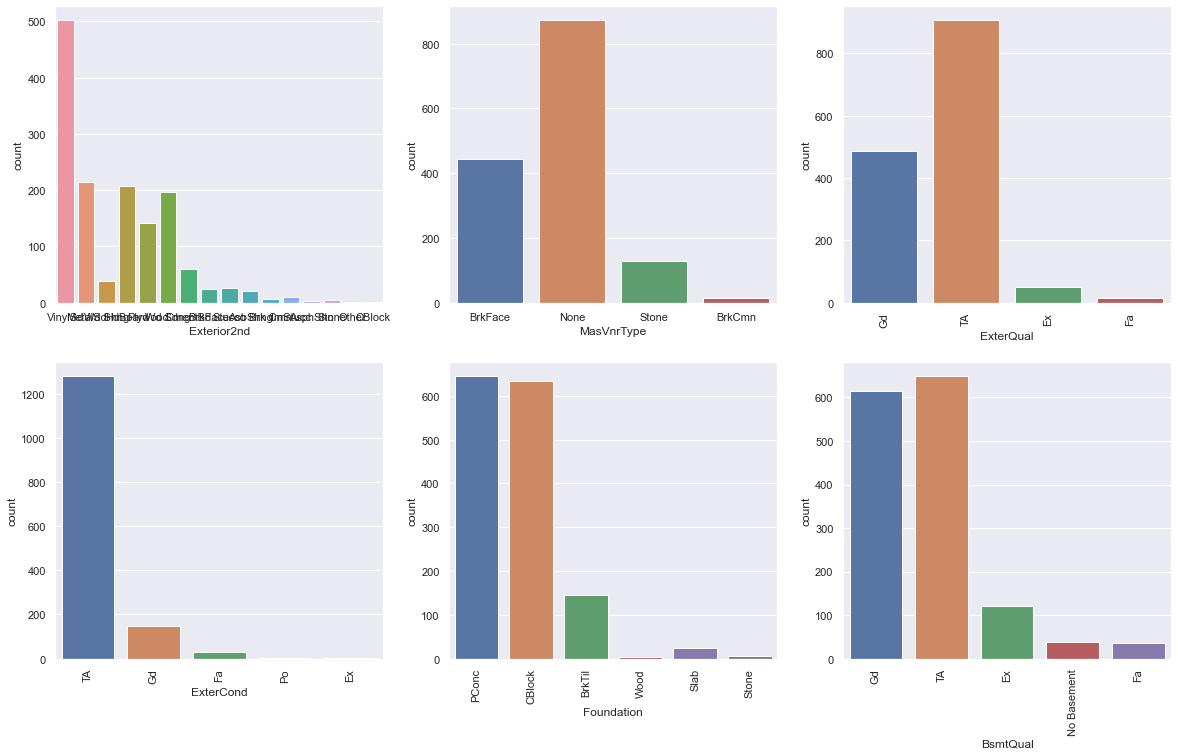

In [3280]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[18],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[19], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[20], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[21], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[22],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[23],  data = housing)
plt.xticks(rotation=90)
plt.show()

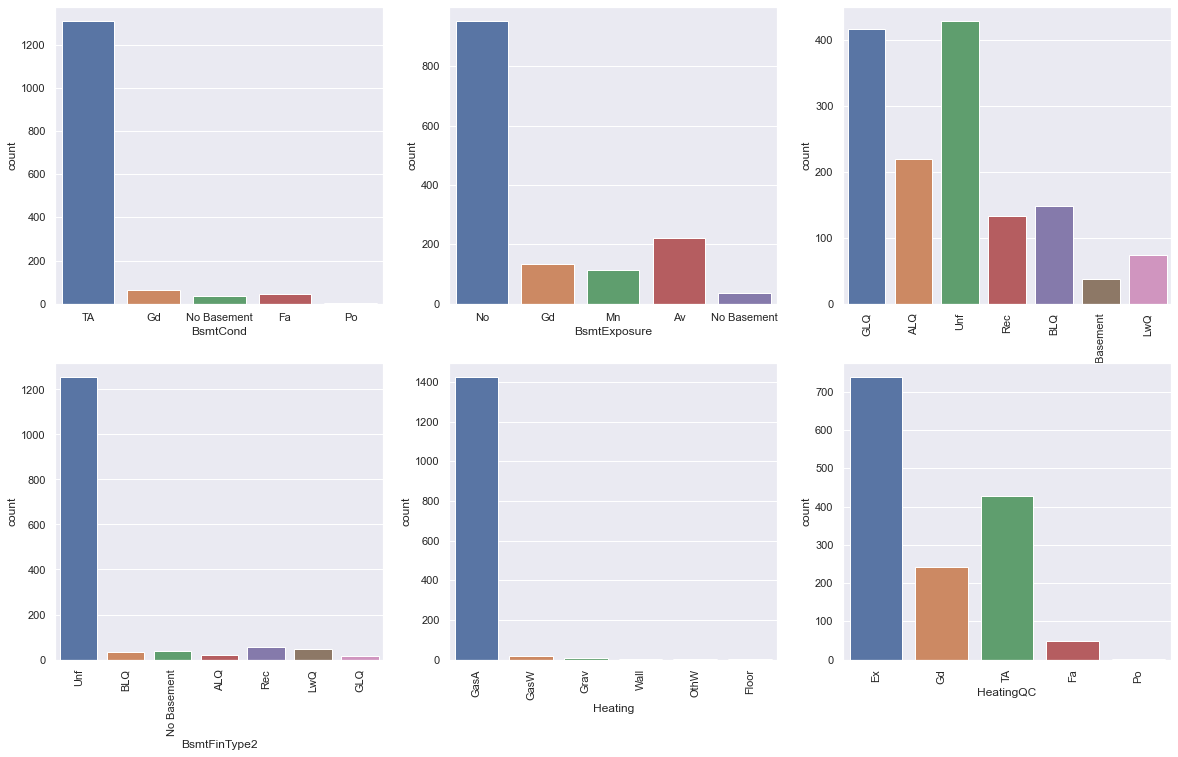

In [3281]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[24],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[25], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[26], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[27], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[28],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[29],  data = housing)
plt.xticks(rotation=90)
plt.show()

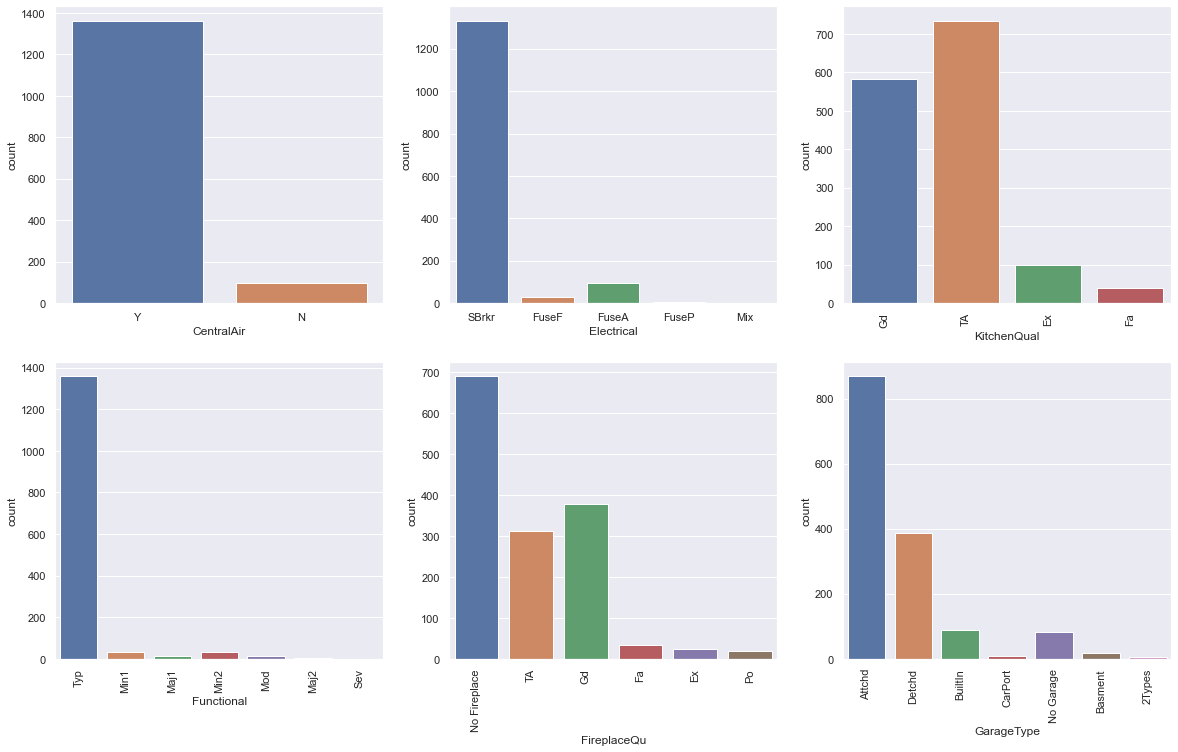

In [3282]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[30],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[31], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[32], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = category_cols[33], data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = category_cols[34],  data = housing)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = category_cols[35],  data = housing)
plt.xticks(rotation=90)
plt.show()

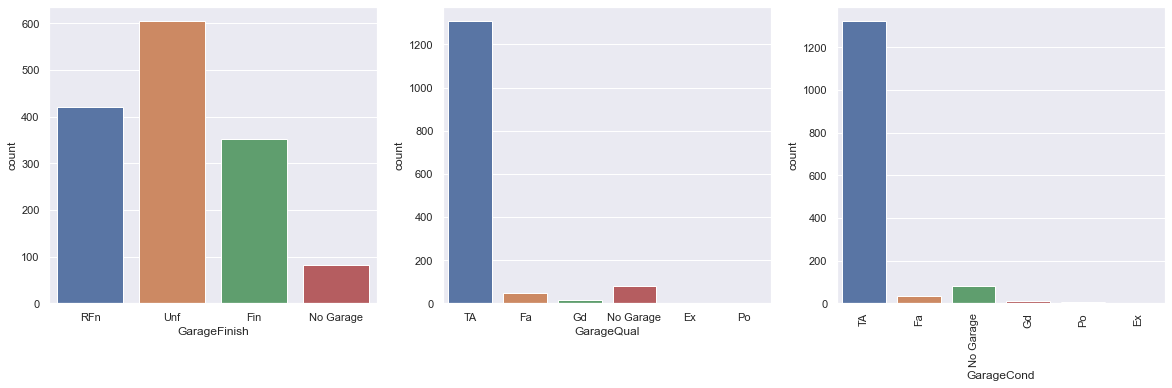

In [3283]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = category_cols[36],  data = housing)
plt.subplot(2,3,2)
sns.countplot(x = category_cols[37], data = housing)
plt.subplot(2,3,3)
sns.countplot(x = category_cols[38], data = housing)
plt.xticks(rotation=90)

plt.show()

### Based on above analysis, the following columns are highly skewed, hence dropping skewed columns

In [3284]:
housing["RoofMatl"].value_counts(1)*100

CompShg    98.216735
Tar&Grv     0.754458
WdShngl     0.411523
WdShake     0.342936
Metal       0.068587
Membran     0.068587
Roll        0.068587
ClyTile     0.068587
Name: RoofMatl, dtype: float64

In [3285]:
housing["Street"].value_counts(1)*100

Pave    99.588477
Grvl     0.411523
Name: Street, dtype: float64

In [3286]:
housing["Condition2"].value_counts(1)*100

Norm      98.971193
Feedr      0.411523
Artery     0.137174
RRNn       0.137174
PosN       0.137174
PosA       0.068587
RRAn       0.068587
RRAe       0.068587
Name: Condition2, dtype: float64

In [3287]:
housing["Heating"].value_counts(1)*100

GasA     97.805213
GasW      1.234568
Grav      0.480110
Wall      0.274348
OthW      0.137174
Floor     0.068587
Name: Heating, dtype: float64

In [3288]:
housing["Utilities"].value_counts(1)*100

AllPub    99.931413
NoSeWa     0.068587
Name: Utilities, dtype: float64

In [3289]:
### Based on above analysis, the following columns are highly skewed, hence dropping skewed columns
skewedcols=["RoofMatl","Street","Utilities","Condition2","Heating"]

In [3290]:
housing=housing.drop(axis=1,  columns=skewedcols)

In [3291]:
housing.shape

(1458, 65)

### Model building

In [3343]:
independentcols=[] 
dependentsvar=[]
for col in housing.columns:
    if col=="SalePrice":
        dependentsvar.append(col)
    else:
        independentcols.append(col)


In [3344]:
independentcols

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition',
 'AgeofProperty']

In [3345]:
dependentsvar

['SalePrice']

In [3346]:
# split into X and y
X = housing.loc[:,independentcols] # predictors in variable X

y = housing['SalePrice'] # response variable in Y

In [3347]:
housing_categorical = X.select_dtypes(include=['object'])
housing_categorical.head()

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,Gd,Typ,No Fireplace,Attchd,RFn,TA,TA,Y,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,2-STORY 1946 & NEWER,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,2-STORY 1945 & OLDER,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


### Cretaing dummy variables for categorical columns

In [3348]:
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.head()

,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [3349]:
X = X.drop(list(housing_categorical.columns), axis=1)

In [3350]:
# concat dummy variables with X
X = pd.concat([X, housing_dummies], axis=1)

In [3351]:
X.columns


Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=247)

### Since No Basement was a category in multiple columns, after dummy variables creation, there will be multiple columns with same meaning, hence dropping duplicates

In [3352]:
dupcols=[]
for col in X.columns:
    if "No Basement" in col:
        dupcols.append(col)


In [3353]:
dupcols

['BsmtQual_No Basement',
 'BsmtCond_No Basement',
 'BsmtExposure_No Basement',
 'BsmtFinType1_No Basement',
 'BsmtFinType2_No Basement']

### Since No Garage was a category in multiple columns, after dummy variables creation, there will be multiple columns with same meaning, hence dropping duplicates

In [3354]:
for col in X.columns:
    if "No Garage" in col:
        dupcols.append(col)

In [3355]:
dupcols

['BsmtQual_No Basement',
 'BsmtCond_No Basement',
 'BsmtExposure_No Basement',
 'BsmtFinType1_No Basement',
 'BsmtFinType2_No Basement',
 'GarageType_No Garage',
 'GarageFinish_No Garage',
 'GarageQual_No Garage',
 'GarageCond_No Garage']

In [3356]:
X["No garage"]=X["GarageType_No Garage"]

In [3357]:
X["No Basement"]=X["BsmtExposure_No Basement"]

In [3358]:
X= X.drop(dupcols,axis=1)     

In [3359]:
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'No garage', 'No Basement'],
      dtype='object', length=240)

### Applying Scaling features (Standard Scaling)

In [3360]:

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'No garage', 'No Basement'],
      dtype='object', length=240)

In [3361]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'No garage', 'No Basement'],
      dtype='object', length=240)

### Splitting in train and test

In [3362]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size = 0.2, random_state=1000)

### Applying Linear Regression

In [3363]:

lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [3364]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

1376134276.2669854
[-1.37355870e-02  1.56884630e-02 -5.98879399e-04 -2.59098248e-02
 -1.74093324e-02  1.72104118e-02 -4.89691990e+10 -5.52931520e+10
 -6.16284230e+09  6.65971740e+10  2.41889954e-02  5.61171770e-03
  3.25260162e-02  2.49710083e-02  8.43584538e-03 -1.26495361e-02
  1.62637234e-02  2.84767151e-03  4.33440208e-02  7.03334808e-03
  1.20806694e-02  2.51817703e-03  6.44183159e-03 -8.38470459e-03
 -9.73701477e-04 -3.66687775e-04 -2.75111198e-02  3.25119495e-02
 -5.91850281e-03  2.37836838e-02 -1.34449005e-02 -4.11820412e-03
  5.09119034e-03  7.45964050e-03  7.97224045e-03 -6.96372986e-03
 -2.89220810e-02  8.29206024e+10 -4.42695618e-03  5.06401062e-03
  7.03740120e-03  9.07888412e-02  3.88174057e-02  1.66360378e-01
  1.23514175e-01  2.93636322e-03 -3.26156616e-04  8.31413269e-03
  1.49593353e-02  1.25684738e-02  2.84116268e-02  8.65936279e-03
 -6.85596466e-03 -5.14411926e-03 -7.68280029e-03  1.25198364e-02
 -3.24535370e-03 -1.44052505e-03  4.32968140e-04  1.08118057e-02
  1.45

### Calculate the R2 on train test, RSS and MSE

In [3365]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9267526612912651
-9.234690012958966e+22
13.816799085367052
4.026279034480628e+24
0.01184974192570073
1.378862683041311e+22


### Since there are too many features, applying RFE to get to the 35 optimal features

In [3366]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=35)
rfe = rfe.fit(X_train, y_train)


In [3367]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 69),
 ('LotArea', False, 64),
 ('MasVnrArea', False, 198),
 ('BsmtFinSF1', False, 44),
 ('BsmtUnfSF', False, 80),
 ('TotalBsmtSF', False, 128),
 ('1stFlrSF', False, 34),
 ('2ndFlrSF', False, 27),
 ('LowQualFinSF', False, 35),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('BsmtHalfBath', False, 119),
 ('FullBath', False, 2),
 ('HalfBath', False, 10),
 ('BedroomAbvGr', False, 127),
 ('KitchenAbvGr', False, 47),
 ('TotRmsAbvGrd', False, 4),
 ('Fireplaces', False, 171),
 ('GarageCars', True, 1),
 ('GarageArea', False, 95),
 ('WoodDeckSF', False, 25),
 ('OpenPorchSF', False, 172),
 ('3SsnPorch', False, 108),
 ('PoolArea', False, 98),
 ('MiscVal', False, 185),
 ('MoSold', False, 202),
 ('AgeofProperty', True, 1),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', False, 55),
 ('MSSubClass_1-STORY 1945 & OLDER', False, 167),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', True, 1),
 ('MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
  False,
  104

In [3368]:
independentvariables=X_train.columns[rfe.support_]


In [3369]:
len(independentvariables)

35

In [3370]:
X_train.shape

(1166, 240)

In [3371]:
X_train_rfe=X_train[independentvariables]

### Appying Linear regression on the RFE features

In [3372]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train_rfe, y_train)


LinearRegression()

In [3373]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

12.022705762333985
[ 0.14197403  0.03404437  0.0554453  -0.06625941  0.02753441 -0.0300319
  0.0455807   0.05416996  0.02484638  0.03082698  0.02404179 -0.03001159
 -0.03497052  0.04637748 -0.0269759   0.03258646  0.05437058 -0.03239133
 -0.03059316  0.02724885  0.03092477 -0.02928266 -0.03311724 -0.06014789
 -0.02336836 -0.06800363 -0.02633892 -0.11170216  0.05549794  0.03124899
  0.02575781  0.11361791  0.05978133  0.02985417 -0.03193923]


In [3374]:
X_test_rfe=X_test[independentvariables]

In [3375]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred_train = lm.predict(X_train_rfe)
y_pred_test = lm.predict(X_test_rfe)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8760131682935486
0.8689896346371044
23.387896039900312
5.71198693859847
0.020058229879845894
0.01956159910478928


In [3376]:
### Applying Ridge regression

In [3377]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 


Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   60, 70, 80, 90, 100, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [3378]:
print(model_cv.best_params_)

{'alpha': 300}


In [3379]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = 300
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-3.00622239e-03  1.25119053e-02  6.36382748e-03  4.85443186e-03
  4.60223991e-03  1.51228554e-02  2.49879005e-02  1.68204169e-02
  6.95872303e-03  3.29830339e-02  1.66991853e-02  5.15516928e-04
  2.56601857e-02  1.98226017e-02  8.70223650e-03 -8.77625499e-03
  2.51973921e-02  1.26566991e-02  2.73761439e-02  1.85953002e-02
  1.12238506e-02  3.24593011e-03  5.58845817e-03 -7.76647104e-03
 -9.51220362e-04  4.23980529e-04 -1.45341496e-02  7.46418758e-04
 -1.41914655e-02  9.54656582e-03 -3.99016112e-03 -2.14854968e-03
 -5.81119119e-04  7.53633583e-03  5.42029627e-03  1.27834218e-03
 -1.20161144e-02 -1.69074320e-03 -3.11692600e-03  1.13307869e-03
  8.71599589e-04  1.00713260e-02  8.12296261e-04  1.25056574e-02
 -5.00349959e-03  7.26316786e-03 -4.36020332e-03  5.94973644e-04
  5.74855917e-03  1.42858115e-03  1.20177760e-02  8.48209300e-03
 -4.35111359e-03 -3.24743102e-03 -4.45416501e-03  6.69275574e-03
 -1.08284079e-03 -8.82144123e-04 -3.23256053e-03  4.53700619e-03
  1.04085585e-02 -2.36690

### Top predictor variables Ridge Regression

In [3380]:
##Creating a dataframe of features and coefficients

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4), 
                         'Abs_Coefficient_Ridge(Desc_Sort)':abs(ridge.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
ridge_df = ridge_df.sort_values(by='Abs_Coefficient_Ridge(Desc_Sort)', ascending=False)
ridge_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
ridge_df.head(10)  #Top10

,Features,Coefficient,Abs_Coefficient_Ridge(Desc_Sort)
0,GrLivArea,0.0330,0.0330
1,OverallQual_Excellent,0.0291,0.0291
2,GarageCars,0.0274,0.0274
3,FullBath,0.0257,0.0257
4,TotRmsAbvGrd,0.0252,0.0252
5,1stFlrSF,0.0250,0.0250
6,Neighborhood_NridgHt,0.0238,0.0238
7,OverallQual_Very Good,0.0233,0.0233
8,HalfBath,0.0198,0.0198
9,Neighborhood_Crawfor,0.0186,0.0186


In [3381]:
# calculate  metrics such as R2 score, RSS and RMSE

In [3382]:

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9125434809037369
0.8858114106671698
16.497106575621345
4.978565848583134
0.014148461900189833
0.017049883043092923


### Lasso regression

In [3383]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   60, 70, 80, 90, 100, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [3384]:
print(model_cv.best_params_)

{'alpha': 0.001}


In [3385]:
#Fitting Ridge model for alpha  and printing coefficients which have been penalised

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [3386]:
lasso.coef_



array([-7.88192595e-03,  1.29091367e-02,  8.22986730e-04, -2.09392666e-03,
        2.90700106e-05,  3.97168143e-04,  9.74126081e-03,  0.00000000e+00,
        2.05656634e-03,  9.13331261e-02,  2.34667316e-02,  9.33687659e-04,
        3.16184310e-02,  2.48871964e-02,  2.75337968e-03, -1.25622401e-02,
        2.27923430e-02,  1.87821361e-03,  4.60812440e-02,  3.87707621e-03,
        1.11151010e-02,  0.00000000e+00,  5.24715357e-03, -7.91171269e-03,
       -2.92181093e-05, -0.00000000e+00, -2.85319769e-02,  0.00000000e+00,
       -8.91405737e-03,  2.36729747e-02, -0.00000000e+00, -1.74886710e-03,
        0.00000000e+00,  1.00317914e-02,  0.00000000e+00, -9.02022738e-03,
       -1.97176080e-02,  0.00000000e+00, -2.05908196e-03,  6.47614526e-04,
        2.96252189e-03,  2.01446526e-02,  2.84798087e-03,  3.08377408e-02,
        8.79428767e-03,  5.80199707e-03, -1.73511143e-03,  2.44673559e-03,
        8.40657938e-03,  4.35251801e-03,  2.04967285e-02,  8.95276176e-03,
       -3.89817613e-03, -

In [3387]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9200066506383799
0.8893588176953133
15.08931321983002
4.823900661942973
0.012941091955257307
0.016520207746380047


### Top Predictor features : Lasso Regression

In [3388]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), 
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
lasso_df.head(10)  #Top10

,Features,Coefficient,Abs_Coefficient_Lasso(Desc_Sort)
0,GrLivArea,0.0913,0.0913
1,GarageCars,0.0461,0.0461
2,OverallQual_Excellent,0.0353,0.0353
3,OverallQual_Very Good,0.0330,0.0330
4,SaleType_New,0.0326,0.0326
5,FullBath,0.0316,0.0316
6,Neighborhood_NridgHt,0.0315,0.0315
7,MSZoning_RL,0.0308,0.0308
8,SaleCondition_Normal,0.0306,0.0306
9,AgeofProperty,-0.0285,0.0285


In [3389]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear RegressionRFE': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear RegressionRFE'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear RegressionRFE,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.876013,0.912543,0.920007
1,R2 Score (Test),0.868990,0.885811,0.889359
2,RSS (Train),23.387896,16.497107,15.089313
3,RSS (Test),5.711987,4.978566,4.823901
4,MSE (Train),0.141627,0.118947,0.113759
5,MSE (Test),0.139863,0.130575,0.128531


### Assignment Part 2: Questions

In [3390]:
#Doubling Optimal value of alpha to check results for Ridge Regression

In [3391]:
#Fitting Ridge model for alpha = 600 and printing coefficients which have been penalised
alpha = 600
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 6.85099036e-04  1.13266869e-02  8.08365512e-03  7.89354771e-03
  5.06750200e-03  1.67444696e-02  2.31704307e-02  1.39359934e-02
  5.43633851e-03  2.91109309e-02  1.39155527e-02  1.16592784e-04
  2.19370017e-02  1.60926488e-02  8.86095162e-03 -6.90732512e-03
  2.38767734e-02  1.36075668e-02  2.41698479e-02  1.92535914e-02
  1.07178089e-02  4.48376079e-03  4.89384954e-03 -6.22062871e-03
 -7.38829776e-04  6.80444017e-04 -1.25571412e-02  2.73669168e-04
 -1.38558508e-02  6.89149559e-03 -3.11968767e-03 -1.02128065e-03
 -8.75980977e-04  5.63648340e-03  5.67035650e-03  3.64562090e-03
 -9.68249303e-03 -1.99428053e-03 -3.73253573e-03  7.37831145e-04
  3.14758572e-04  7.72230138e-03  5.83790806e-05  1.01518424e-02
 -7.43963237e-03  6.96596248e-03 -5.04143827e-03 -1.78219538e-03
  4.43314355e-03  7.48648742e-04  7.80373227e-03  7.83916474e-03
 -3.27637440e-03 -2.08952377e-03 -3.47598281e-03  4.79782984e-03
 -3.74199766e-04 -3.50050138e-04 -3.57624569e-03  3.02810117e-03
  8.53915789e-03 -2.14658

In [3392]:
##Creating a dataframe of features and coefficients

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4), 
                         'Abs_Coefficient_Ridge(Desc_Sort)':abs(ridge.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
ridge_df = ridge_df.sort_values(by='Abs_Coefficient_Ridge(Desc_Sort)', ascending=False)
ridge_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
ridge_df.head(10)  #Top10

,Features,Coefficient,Abs_Coefficient_Ridge(Desc_Sort)
0,GrLivArea,0.0291,0.0291
1,OverallQual_Excellent,0.0259,0.0259
2,GarageCars,0.0242,0.0242
3,TotRmsAbvGrd,0.0239,0.0239
4,1stFlrSF,0.0232,0.0232
5,FullBath,0.0219,0.0219
6,Neighborhood_NridgHt,0.0205,0.0205
7,OverallQual_Very Good,0.0196,0.0196
8,GarageArea,0.0193,0.0193
9,TotalBsmtSF,0.0167,0.0167


In [3393]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric4.append(mse_test_lr**0.5)

0.9035103695566173
0.8821045670683139
18.20104130962168
5.14018239061355
0.0156098124439294
0.017603364351416267


In [3394]:
#Doubling Optimal value of alpha to check results for Ridge Regression

#Fitting Ridge model for alpha  and printing coefficients which have been penalised

alpha =0.002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.002)

In [3395]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric5.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric5.append(mse_test_lr**0.5)

0.91541702494381
0.8930294094500303
15.95506393810626
4.663864682333309
0.01368358828311
0.015972139323059277


In [3396]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), 
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
lasso_df.head(10)  #Top10

,Features,Coefficient,Abs_Coefficient_Lasso(Desc_Sort)
0,GrLivArea,0.0872,0.0872
1,GarageCars,0.0466,0.0466
2,OverallQual_Excellent,0.0385,0.0385
3,OverallQual_Very Good,0.0343,0.0343
4,Neighborhood_NridgHt,0.0311,0.0311
5,FullBath,0.0298,0.0298
6,SaleType_New,0.0288,0.0288
7,AgeofProperty,-0.0256,0.0256
8,SaleCondition_Normal,0.0255,0.0255
9,Neighborhood_Crawfor,0.0255,0.0255


In [3398]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear RegressionRFE': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear RegressionRFE'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

rg_metric_2 = pd.Series(metric4, name = 'Ridge Regression Alpha Double')
ls_metric_2 = pd.Series(metric5, name = 'Lasso Regression Alpha Double')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric,rg_metric_2,ls_metric_2], axis = 1)

final_metric

,Metric,Linear RegressionRFE,Ridge Regression,Lasso Regression,Ridge Regression Alpha Double,Lasso Regression Alpha Double
0,R2 Score (Train),0.876013,0.912543,0.920007,0.903510,0.915417
1,R2 Score (Test),0.868990,0.885811,0.889359,0.882105,0.893029
2,RSS (Train),23.387896,16.497107,15.089313,18.201041,15.955064
3,RSS (Test),5.711987,4.978566,4.823901,5.140182,4.663865
4,MSE (Train),0.141627,0.118947,0.113759,0.124939,0.116977
5,MSE (Test),0.139863,0.130575,0.128531,0.132678,0.126381


In [ ]:
## If top 5 predictor variables are not available in Lasso

In [3408]:
dropfeatures=['GrLivArea','GarageCars','OverallQual_Excellent','OverallQual_Very Good','SaleType_New']

X_train=X_train.drop(axis=1,  columns=dropfeatures)
X_test=X_test.drop(axis=1,  columns=dropfeatures)

In [3403]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   60, 70, 80, 90, 100, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [3404]:
print(model_cv.best_params_)

{'alpha': 0.001}


In [3405]:

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [3409]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)


r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)


rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)


rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)


mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)


mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)


0.9155416869192867
0.8794276858525134
15.931548688281344
5.256893083683351
0.013663420830429969
0.0180030585057649


In [3410]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), 
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
lasso_df.head(10)  #Top10

,Features,Coefficient,Abs_Coefficient_Lasso(Desc_Sort)
0,1stFlrSF,0.0721,0.0721
1,2ndFlrSF,0.0630,0.0630
2,KitchenQual_TA,-0.0469,0.0469
3,GarageArea,0.0384,0.0384
4,Neighborhood_NridgHt,0.0374,0.0374
5,FullBath,0.0361,0.0361
6,TotRmsAbvGrd,0.0351,0.0351
7,MSZoning_RL,0.0327,0.0327
8,AgeofProperty,-0.0323,0.0323
9,KitchenQual_Gd,-0.0314,0.0314
